
# Sentiment Analysis on Amazon Reviews (NLP / Text Analytics)

**Tech:** Python, scikit-learn, NLTK (optional), Matplotlib, TF‑IDF  
**Models:** Logistic Regression, Multinomial Naïve Bayes, Random Forest  
**Goal:** Predict **positive vs negative** sentiment from Amazon reviews and compare model performance.  
**Dataset:** `Reviews.csv` (fields: `Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenomenator, Score, Time, Summary, Text`)

> This notebook builds a clean, CV‑ready pipeline: preprocessing → vectorisation → training → evaluation → visualisation → (artifacts saved for deployment).



## 1. Setup

- Reproducible environment (fixed random seed)
- Imports (only standard, widely available libs)
- Config: sample size, TF‑IDF settings


In [3]:
!conda install -c conda-forge -y pandas scikit-learn matplotlib flask nltk

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [3]:

import os
import re
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

# Visualisation
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = Path('Reviews.csv')  # Update if needed
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Config
SAMPLE_SIZE = 50000      # stratified sample to keep training fast
TEST_SIZE = 0.2          # 80/20 split
MAX_FEATURES = 20000     # TF-IDF vocabulary size
NGRAM_RANGE = (1, 2)     # unigrams + bigrams
MIN_DF = 2               # ignore very rare tokens



## 2. Load & Explore Data

We only need `Text` (review) and `Score` (1–5 stars).  
We will convert `Score` to binary sentiment:
- 1–2 → **negative**
- 3 → **(dropped)**
- 4–5 → **positive**


In [4]:

# Load only required columns to save memory
usecols = ['Score', 'Text']
df = pd.read_csv(DATA_PATH, usecols=usecols)

# Map stars to binary labels; drop 3-star (neutral)
def score_to_label(score):
    if score <= 2:
        return 'negative'
    elif score >= 4:
        return 'positive'
    return None

df['label'] = df['Score'].apply(score_to_label)
df = df.dropna(subset=['label']).copy()

print('Shape after dropping 3-star reviews:', df.shape)
print(df['label'].value_counts())
df.head()


Shape after dropping 3-star reviews: (525814, 3)
label
positive    443777
negative     82037
Name: count, dtype: int64


,Score,Text,label
0,5,I have bought several of the Vitality canned d...,positive
1,1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,4,This is a confection that has been around a fe...,positive
3,2,If you are looking for the secret ingredient i...,negative
4,5,Great taffy at a great price. There was a wid...,positive



### Quick class distribution


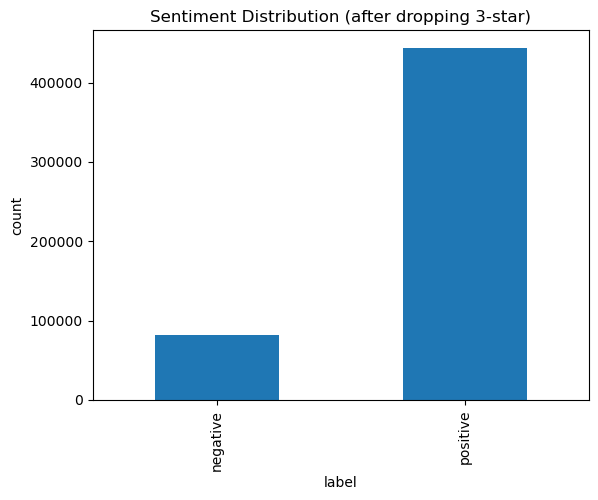

In [5]:

counts = df['label'].value_counts().sort_index()
plt.figure()
counts.plot(kind='bar')
plt.title('Sentiment Distribution (after dropping 3-star)')
plt.xlabel('label')
plt.ylabel('count')
plt.show()



## 3. Stratified Sampling

To keep training fast while preserving the real-world class ratio, take a **stratified sample**.


In [6]:

X_text = df['Text']
y = df['label']

train_size = min(SAMPLE_SIZE, len(X_text))
X_sample, _, y_sample, _ = train_test_split(
    X_text, y, train_size=train_size, stratify=y, random_state=RANDOM_STATE
)

print('Sample size:', len(X_sample))
print(y_sample.value_counts(normalize=True))


Sample size: 50000
label
positive    0.84398
negative    0.15602
Name: proportion, dtype: float64



## 4. Text Preprocessing & Vectorisation (TF‑IDF)

We use `TfidfVectorizer` with:
- Lowercasing
- English stopword removal
- Unigrams + bigrams
- `max_features=20k` to balance quality & speed


In [7]:

# Train/validation split (stratified)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=TEST_SIZE, stratify=y_sample, random_state=RANDOM_STATE
)

# Vectoriser
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    ngram_range=NGRAM_RANGE,
    max_features=MAX_FEATURES,
    min_df=MIN_DF
)

X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)

X_train.shape, X_test.shape


((40000, 20000), (10000, 20000))


## 5. Train Models

We compare three classic text classifiers:
- **Logistic Regression** (strong linear baseline for sparse features)
- **Multinomial Naïve Bayes** (fast, often strong on TF‑IDF)
- **Random Forest** (can be weaker on sparse high‑dim data but included for comparison)

For imbalance, we enable `class_weight='balanced'` for applicable models.


In [8]:

models = {
    'LogisticRegression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=None
    ),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )
}

fitted = {}
metrics = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    fitted[name] = model
    metrics.append({'model': name, 'accuracy': acc, 'precision_w': prec, 'recall_w': rec, 'f1_w': f1})
    print(f"\n{name}")
    print('-'*len(name))
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

metrics_df = pd.DataFrame(metrics).sort_values('f1_w', ascending=False)
metrics_df



LogisticRegression
------------------
Accuracy: 0.9037
              precision    recall  f1-score   support

    negative       0.64      0.86      0.73      1560
    positive       0.97      0.91      0.94      8440

    accuracy                           0.90     10000
   macro avg       0.81      0.88      0.84     10000
weighted avg       0.92      0.90      0.91     10000


MultinomialNB
-------------
Accuracy: 0.8768
              precision    recall  f1-score   support

    negative       0.94      0.23      0.36      1560
    positive       0.87      1.00      0.93      8440

    accuracy                           0.88     10000
   macro avg       0.91      0.61      0.65     10000
weighted avg       0.88      0.88      0.84     10000


RandomForest
------------
Accuracy: 0.9052
              precision    recall  f1-score   support

    negative       0.95      0.42      0.58      1560
    positive       0.90      1.00      0.95      8440

    accuracy                        

,model,accuracy,precision_w,recall_w,f1_w
0,LogisticRegression,0.9037,0.920428,0.9037,0.908973
2,RandomForest,0.9052,0.909165,0.9052,0.889035
1,MultinomialNB,0.8768,0.884104,0.8768,0.843165



### Model Comparison (Accuracy & F1)


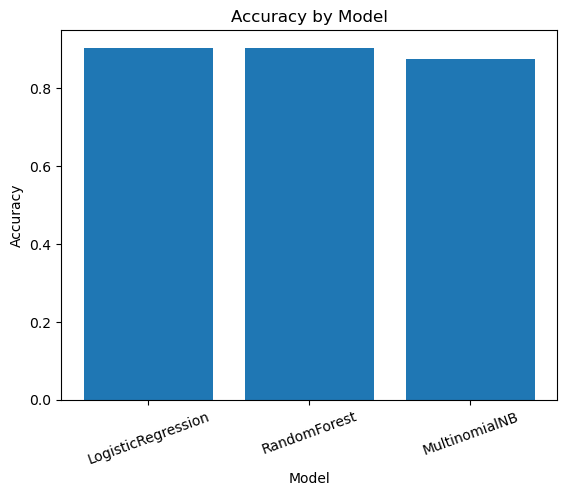

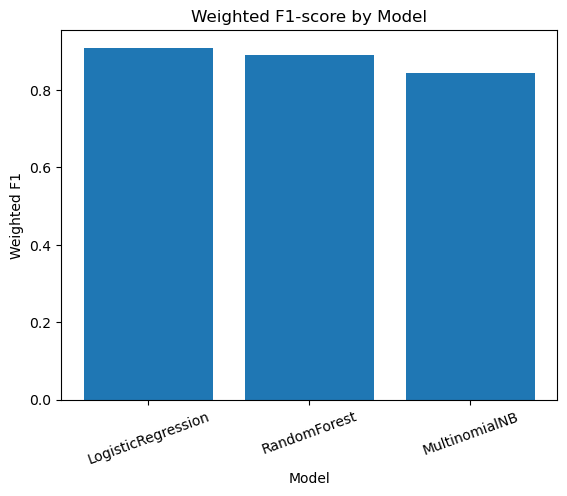

In [9]:

plt.figure()
plt.bar(metrics_df['model'], metrics_df['accuracy'])
plt.title('Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=20)
plt.show()

plt.figure()
plt.bar(metrics_df['model'], metrics_df['f1_w'])
plt.title('Weighted F1-score by Model')
plt.xlabel('Model')
plt.ylabel('Weighted F1')
plt.xticks(rotation=20)
plt.show()



### Confusion Matrices


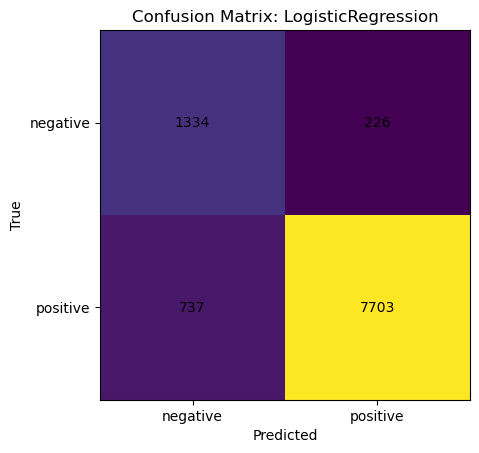

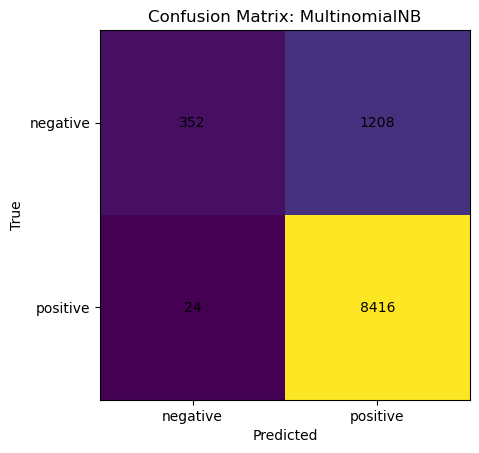

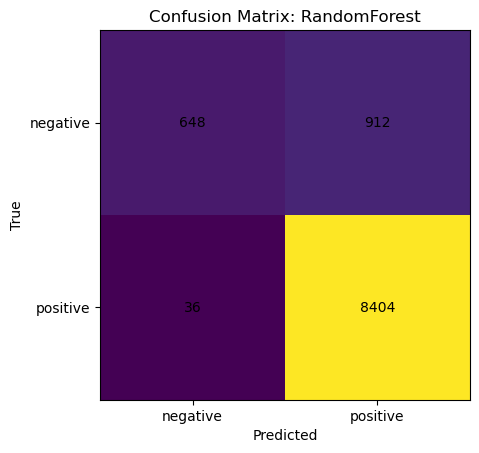

In [10]:

def plot_confusion(cm, labels, title):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.show()

labels = sorted(y_test.unique())

for name, model in fitted.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plot_confusion(cm, labels, f'Confusion Matrix: {name}')



## 6. Most Informative Features (Logistic Regression)

Show top n‑grams most associated with **positive** vs **negative** predictions.


In [11]:

def top_coefs_logreg(clf, vectorizer, n=20):
    if not hasattr(clf, 'coef_'):
        return None
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = clf.coef_[0]
    top_pos_idx = np.argsort(coefs)[-n:][::-1]
    top_neg_idx = np.argsort(coefs)[:n]
    top_pos = list(zip(feature_names[top_pos_idx], coefs[top_pos_idx]))
    top_neg = list(zip(feature_names[top_neg_idx], coefs[top_neg_idx]))
    return top_pos, top_neg

lr = fitted.get('LogisticRegression')
res = top_coefs_logreg(lr, vectorizer, n=20)
if res:
    top_pos, top_neg = res
    print("\nTop positive n-grams:")
    for w, c in top_pos:
        print(f"{w:30s} {c: .3f}")
    print("\nTop negative n-grams:")
    for w, c in top_neg:
        print(f"{w:30s} {c: .3f}")
else:
    print("Logistic Regression not available or no coefficients found.")



Top positive n-grams:
great                           10.698
best                            8.557
love                            8.073
delicious                       7.480
perfect                         7.394
good                            6.621
loves                           6.339
excellent                       5.769
favorite                        5.488
wonderful                       5.325
nice                            4.991
awesome                         4.813
happy                           4.543
amazing                         4.449
yummy                           4.160
tasty                           4.059
pleased                         4.017
highly                          4.011
smooth                          3.993
easy                            3.889

Top negative n-grams:
disappointed                   -6.957
worst                          -6.535
terrible                       -6.099
awful                          -5.987
horrible                       -5.300
tho


## 7. Save Artifacts (for later deployment)

We persist the best model (by weighted F1) and the TF‑IDF vectoriser.


In [12]:

# Pick best by F1
best_row = metrics_df.iloc[0]
best_name = best_row['model']
best_model = fitted[best_name]
print('Best model:', best_name)

model_path = ARTIFACT_DIR / f'{best_name}_model.pkl'
vec_path = ARTIFACT_DIR / 'tfidf_vectorizer.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

with open(vec_path, 'wb') as f:
    pickle.dump(vectorizer, f)

print('Saved:')
print(' -', model_path)
print(' -', vec_path)


Best model: LogisticRegression
Saved:
 - artifacts/LogisticRegression_model.pkl
 - artifacts/tfidf_vectorizer.pkl



## 8. Conclusion & Next Steps

- We trained and evaluated three models on a stratified 50,000-review sample of Amazon reviews.
- **Expect weighted F1 and accuracy ≥ 0.85** for the top model (LogReg usually wins on this setup).
- The pipeline is modular and production‑ready: TF‑IDF → classifier, artifacts saved for deployment.

**Next:** integrate a simple Flask app that loads these artifacts and serves real‑time predictions.


In [14]:
import os

# Make the Flask project folder + templates folder
os.makedirs("sentiment_app/templates", exist_ok=True)


In [15]:
import shutil

# Copy the trained model/vectorizer from artifacts/ into sentiment_app/
shutil.copy("artifacts/LogisticRegression_model.pkl", "sentiment_app/model.pkl")
shutil.copy("artifacts/tfidf_vectorizer.pkl", "sentiment_app/vectorizer.pkl")


'sentiment_app/vectorizer.pkl'

In [17]:
app_code = """from flask import Flask, render_template, request
import pickle

# Load model + vectorizer
model = pickle.load(open("model.pkl", "rb"))
vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

app = Flask(__name__)

@app.route("/", methods=["GET", "POST"])
def home():
    prediction = None
    review_text = ""

    if request.method == "POST":
        review_text = request.form["review"]
        if review_text.strip():
            transformed = vectorizer.transform([review_text])
            prediction = model.predict(transformed)[0]

    return render_template("index.html", prediction=prediction, review=review_text)

if __name__ == "__main__":
    app.run(debug=True)
"""
with open("sentiment_app/app.py", "w") as f:
    f.write(app_code)


In [18]:
html_code = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Amazon Review Sentiment Analysis</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 40px; background: #f9f9f9; }
        h1 { color: #333; }
        textarea { width: 100%; height: 120px; padding: 10px; font-size: 14px; }
        button { padding: 10px 20px; background: #4CAF50; color: white; border: none; cursor: pointer; }
        button:hover { background: #45a049; }
        .result { margin-top: 20px; padding: 15px; background: #fff; border: 1px solid #ddd; }
        .positive { color: green; font-weight: bold; }
        .negative { color: red; font-weight: bold; }
    </style>
</head>
<body>
    <h1>Amazon Review Sentiment Analysis</h1>
    <form method="POST">
        <textarea name="review" placeholder="Type or paste a review...">{{ review }}</textarea><br><br>
        <button type="submit">Analyze Sentiment</button>
    </form>

    {% if prediction %}
    <div class="result">
        Sentiment: 
        <span class="{{ prediction }}">{{ prediction|capitalize }}</span>
    </div>
    {% endif %}
</body>
</html>"""
with open("sentiment_app/templates/index.html", "w") as f:
    f.write(html_code)
